# **Text Translation with LSTM Networks**

This notebook demonstrates the implementation of an English-to-Spanish text translation model using [LSTM networks](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) with an [Attention mechanism](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention). The model is trained on the [ManyThings dataset](https://www.manythings.org/anki/), specifically the Spanish-English pair, which currently contains 141,543 records.

**For a more advanced implementation, please visit my [notebook](https://github.com/JersonGB22/Translation-TensorFlow/blob/main/models_transformers/TranslationEN-ES_MarianMT_ManyThings.ipynb), where a Transformer model is used for text translation, achieving better results.**

## **Imports**

In [ ]:
# Download the libraries to evaluate the translation
!pip install evaluate -q
!pip install sacrebleu -q

In [ ]:
import tensorflow as tf
from evaluate import load
import numpy as np
import re
import plotly.graph_objects as go
from google.colab import drive
from IPython.core.display import HTML
import textwrap
from tqdm.auto import tqdm

In [ ]:
# Installing TensorFlow Text
version_tf = tf.__version__
print(version_tf)
!pip install tensorflow_text==$version_tf -q

import tensorflow_text as tf_text

2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.2 MB/s eta 0:00:00


## **Parameters**

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
batch_size = 128
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123
embedding_dim = 256
vocab_size = 25000
epochs = 20

## **Load and Preprocess the Dataset**

In [ ]:
data_url = "https://www.manythings.org/anki/spa-eng.zip"

# Download dataset
!wget -q $data_url

# Unzip the dataset
!unzip -q /content/spa-eng.zip

The `contexts` variable contains the records in English, which is the source language in this case, while the `targets` variable contains the records in Spanish, the target language for translation. The initial records are short and progressively increase in length, so the later records are longer.

In [ ]:
def load_data(path):
  contexts, targets = [], []
  with open(path, "r") as file:
    for line in file:
      line = line.split("\t")
      contexts.append(line[0])
      targets.append(line[1])
  return np.array(contexts), np.array(targets)

In [ ]:
contexts, targets = load_data("/content/spa.txt")
len(contexts)

141543

In [ ]:
# Viewing the first 10 examples
print(contexts[:10])
print(targets[:10])

['Go.' 'Go.' 'Go.' 'Go.' 'Hi.' 'Run!' 'Run!' 'Run!' 'Run!' 'Run!']
['Ve.' 'Vete.' 'Vaya.' 'Váyase.' 'Hola.' '¡Corre!' '¡Corran!' '¡Huye!'
 '¡Corra!' '¡Corred!']


### **Text Tokenization**

For tokenization, the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer is used for both English and Spanish sequences. This layer encodes the text into frequency-ordered indices, following the padding token and the unknown token, considering up to `vocab_size`. The `standardize` argument allows for the passing of a text preprocessing function, which includes Unicode normalization using [TensorFlow Text](https://www.tensorflow.org/text). This is particularly useful for splitting compound characters in Spanish that have accents (´), diaeresis (¨), and tilde (~), effectively removing these diacritical marks. Additionally, the `[START]` and `[END]` tokens are appended at the end of this preprocessing step to indicate when the model should start and stop the translation. Finally, with the `ragged=True` argument, sequences are treated as variable-length, dynamically padding them with 0 (padding token) to the length of the longest sequence in the batch.

In [ ]:
# Create a custom standardization function

def preprocessing(text):
  # Normalize text to UTF-8 by decomposing composite characters into their basic elements
  text = tf_text.normalize_utf8(text, "NFKD")
  # Convert all text to lowercase
  text = tf.strings.lower(text)
  # Keep only alphabetic characters and certain punctuation marks
  text = tf.strings.regex_replace(text, r"[-—_/]", " ") #For compound words
  text = tf.strings.regex_replace(text, r"[^ a-z0-9.,;:¿?¡!]", "")
  # Add spaces around punctuation
  text = tf.strings.regex_replace(text, r"[.,;:¿?¡!]", r" \0 ")
  # Remove all redundant white spaces
  text = tf.strings.regex_replace(tf.strings.strip(text), r"\s+", " ")
  # Add start and end tokens to the text
  text = tf.strings.join(["[START]", text, "[END]"], separator=" ")
  return text

In [ ]:
# Example of text preprocessing
id = -1
example_context = tf.constant(contexts[id])
example_target = tf.constant(targets[id])

print(f"Unstandardized Context:\n{textwrap.fill(example_context.numpy().decode('utf-8'), width=75)}\n")
print(f"Standardized Context:\n{textwrap.fill(preprocessing(example_context).numpy().decode('utf-8'), width=75)}\n\n")

print(f"Unstandardized Target:\n{textwrap.fill(example_target.numpy().decode('utf-8'), width=75)}\n")
print(f"Standardized Target:\n{textwrap.fill(preprocessing(example_target).numpy().decode('utf-8'), width=75)}")

Unstandardized Context:
One day, I woke up to find that God had put hair on my face. I shaved it
off. The next day, I found that God had put it back on my face, so I shaved
it off again. On the third day, when I found that God had put hair back on
my face again, I decided to let God have his way. That's why I have a
beard.

Standardized Context:
[START] one day , i woke up to find that god had put hair on my face . i
shaved it off . the next day , i found that god had put it back on my face
, so i shaved it off again . on the third day , when i found that god had
put hair back on my face again , i decided to let god have his way . thats
why i have a beard . [END]


Unstandardized Target:
Un día, me desperté y vi que Dios me había puesto pelo en la cara. Me lo
afeité. Al día siguiente, vi que Dios me lo había vuelto a poner en la
cara, así que me lo afeité otra vez. Al tercer día, cuando vi que Dios me
había puesto pelo en la cara de nuevo, decidí que Dios se saliera con la
suya. Por es

In [ ]:
context_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    standardize=preprocessing,
    ragged=True
)
context_vectorizer.adapt(contexts)

context_vocab = np.array(context_vectorizer.get_vocabulary())
context_vocab_size = context_vectorizer.vocabulary_size()
print(context_vocab_size)
context_vocab[:10]

14189


array(['', '[UNK]', '[START]', '[END]', '.', 'i', 'the', 'to', 'you',
       'tom'], dtype='<U17')

In [ ]:
target_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    standardize=preprocessing,
    ragged=True
)
target_vectorizer.adapt(targets)

target_vocab = np.array(target_vectorizer.get_vocabulary())
target_vocab_size = target_vectorizer.vocabulary_size()
print(target_vocab_size)
target_vocab[:10]

25000


array(['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'no', 'el',
       'tom'], dtype='<U19')

### **Create the training and validation datasets using ``tf.data``**

In [ ]:
def vectorize_text(contexts, targets):
  contexts = context_vectorizer(contexts).to_tensor()
  targets = target_vectorizer(targets)
  targets_in = targets[:, :-1].to_tensor()
  targets_out = targets[:, 1:].to_tensor()
  return (contexts, targets_in), targets_out

In [ ]:
# Take approximately 2000 examples (1.5%) for the evaluation dataset
np.random.seed(SEED) #For reproducibility
is_train = np.random.uniform(size=(len(targets),)) < 0.985

train_dataset= tf.data.Dataset.from_tensor_slices((contexts[is_train], targets[is_train]))
val_dataset= tf.data.Dataset.from_tensor_slices((contexts[~is_train], targets[~is_train]))

print(len(train_dataset), len(val_dataset))

train_dataset = (
    train_dataset.
    shuffle(buffer_size, seed=SEED).
    batch(batch_size).
    map(vectorize_text, num_parallel_calls=AUTOTUNE).
    prefetch(AUTOTUNE)
)

val_dataset = (
    val_dataset.
    batch(batch_size).
    map(vectorize_text, num_parallel_calls=AUTOTUNE).
    prefetch(AUTOTUNE)
)

139424 2119


In [ ]:
# Viewing a training batch
for (inputs, labels_in), labels_out in train_dataset.take(1):
  print(inputs[:5], "\n")
  print(labels_in[:5], "\n")
  print(labels_out[:5])

tf.Tensor(
[[  2   5 632   4   3   0]
 [  2 362  21   4   3   0]
 [  2 458 125   3   0   0]
 [  2 439 125   3   0   0]
 [  2   5 101 545   4   3]], shape=(5, 6), dtype=int64) 

tf.Tensor(
[[    2   861     4     0     0     0     0]
 [    2  2394     4     0     0     0     0]
 [    2    82 14059    81     0     0     0]
 [    2    82  1361    81     0     0     0]
 [    2    18  7387     4     0     0     0]], shape=(5, 7), dtype=int64) 

tf.Tensor(
[[  861     4     3     0     0     0     0]
 [ 2394     4     3     0     0     0     0]
 [   82 14059    81     3     0     0     0]
 [   82  1361    81     3     0     0     0]
 [   18  7387     4     3     0     0     0]], shape=(5, 7), dtype=int64)


## **Creation and Training of the Model**

The model consists of an Encoder that utilizes a bidirectional LSTM to process the context sequence and generate vectors crucial for the decoder, which predicts the next output at each time step. This facilitates smooth information flow within the Encoder. Additionally, it incorporates a Cross-Attention mechanism that enables the decoder to access critical information extracted by the Encoder. The Decoder, in turn, generates predictions for the next token in the target sequence during inference, producing one word at a time and continuously feeding back into the model.

In [ ]:
def Encoder(vocab_size, units):
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=units,
          mask_zero=True, #Indicates that the value 0 is a padding value that should be masked
          input_shape=(None,)
      ),
      tf.keras.layers.Bidirectional(
          tf.keras.layers.LSTM(units, return_sequences=True),
          merge_mode="sum"
      )
  ], name="Encoder")

  return model

In [ ]:
def CrossAttention(units):
  encoded_context = tf.keras.Input(shape=(None, units))
  encoded_target_in = tf.keras.Input(shape=(None, units))

  x = tf.keras.layers.MultiHeadAttention(num_heads=1, key_dim=units)(
      query=encoded_target_in,
      value=encoded_context
  )
  x = tf.keras.layers.Add()([encoded_target_in, x])
  x = tf.keras.layers.LayerNormalization()(x)

  model = tf.keras.Model(
      inputs=[encoded_context, encoded_target_in],
      outputs=x,
      name="CrossAttention"
  )
  return model


@tf.keras.saving.register_keras_serializable()
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, units):
    super().__init__()

    self.embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=units,
        mask_zero=True
    )

    self.pre_attention_lstm = tf.keras.layers.LSTM(
        units,
        return_sequences=True,
        return_state=True
    )

    self.attention = CrossAttention(units)
    self.post_attention_lstm = tf.keras.layers.LSTM(units, return_sequences=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, encoded_context, target_in, states=None, return_state=False):
    x = self.embedding(target_in)
    x, last_hs, last_cs = self.pre_attention_lstm(x, initial_state=states) #(All sequence hidden states, last hidden state, last cell state)
    x = self.attention([encoded_context, x])
    x = self.post_attention_lstm(x)
    x = self.dense(x)

    if return_state:
      return x, [last_hs, last_cs]
    else:
      return x

In [ ]:
@tf.keras.saving.register_keras_serializable()
class Translator(tf.keras.Model):
  def __init__(self, context_vocab_size, target_vocab_size, units):
    super().__init__()
    self.encoder_model = Encoder(context_vocab_size, units)
    self.decoder_model = Decoder(target_vocab_size, units)

  def call(self, inputs):
    context, target_in = inputs
    encoded_context = self.encoder_model(context)
    logits = self.decoder_model(encoded_context, target_in)
    return logits

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(123) #For reproducibility

model = Translator(
    context_vocab_size=context_vocab_size,
    target_vocab_size=target_vocab_size,
    units=embedding_dim
)

model.build([(None, None), (None, None)])
model.call([tf.keras.Input(shape=(None,)), tf.keras.Input(shape=(None,))])
model.summary()

Model: "translator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, None, 256)         4683008   
                                                                 
 decoder (Decoder)           (None, None, 25000)       14139304  
                                                                 
Total params: 18822312 (71.80 MB)
Trainable params: 18822312 (71.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In this case, during model compilation, it's not feasible to use `SparseCategoricalCrossentropy` with the `ignore_class=0` argument to mask the padding token, as sequence lengths vary between batches. Therefore, a custom loss function and custom accuracy metric are implemented to properly manage padding masking.

In [ ]:
def masked_loss(labels, logits):
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True,
      reduction=tf.keras.losses.Reduction.NONE
  )

  loss = loss_fn(labels, logits)
  mask = tf.cast(labels != 0, loss.dtype)
  loss *= mask

  return tf.reduce_sum(loss) / tf.reduce_sum(mask)


def masked_accuracy(y_true, y_pred):
  y_pred = tf.cast(tf.argmax(y_pred, axis=-1), y_true.dtype)
  mask = tf.cast(y_true != 0, tf.float32)
  accuracy = tf.cast(y_true == y_pred, tf.float32)
  accuracy *= mask

  return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

In [ ]:
# Model Compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=masked_loss,
    metrics=[masked_accuracy]
)

In [ ]:
# Callback to stop training early if accuracy does not increase for 3 epochs
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_masked_accuracy",
    patience=3,
    mode="max",
    restore_best_weights=True
)

In [ ]:
# Train the model

tf.random.set_seed(SEED)
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[callback])

Epoch 1/20
1090/1090 [==============================] - 186s 147ms/step - loss: 4.4229 - masked_accuracy: 0.3589 - val_loss: 3.3604 - val_masked_accuracy: 0.4883
Epoch 2/20
1090/1090 [==============================] - 99s 90ms/step - loss: 2.2909 - masked_accuracy: 0.6271 - val_loss: 2.2017 - val_masked_accuracy: 0.6264
Epoch 3/20
1090/1090 [==============================] - 91s 83ms/step - loss: 1.5942 - masked_accuracy: 0.7099 - val_loss: 1.8618 - val_masked_accuracy: 0.6725
Epoch 4/20
1090/1090 [==============================] - 87s 80ms/step - loss: 1.2540 - masked_accuracy: 0.7504 - val_loss: 1.6500 - val_masked_accuracy: 0.7002
Epoch 5/20
1090/1090 [==============================] - 86s 79ms/step - loss: 1.0392 - masked_accuracy: 0.7778 - val_loss: 1.5994 - val_masked_accuracy: 0.7030
Epoch 6/20
1090/1090 [==============================] - 84s 77ms/step - loss: 0.8861 - masked_accuracy: 0.7991 - val_loss: 1.5859 - val_masked_accuracy: 0.7028
Epoch 7/20
1090/1090 [================

**Save model**

In [ ]:
trained_model_path = "/content/drive/MyDrive/models/TranslationEN-ES_LSTMAttention_ManyThings.keras"

In [ ]:
model.save(trained_model_path)

## **Model Evaluation**

### **With conventional Accuracy**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(val_dataset, verbose=0))

[0.5999444723129272, 0.8513826131820679]
[1.5124757289886475, 0.727790892124176]


Conventional accuracy (``train_dataset: 85.14%, val_dataset: 72.78%``) does not accurately reflect the true performance of the translation model, but it serves as a useful approximation during training to assess how well the model is performing. For a more accurate evaluation, the **BLEU** metric will be used.

In [ ]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=len(history.history["loss"])):
  losses = history.history[metric]
  val_losses = history.history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

**Interactive graphics**

In [ ]:
plot_metrics()
plot_metrics(metric="masked_accuracy")

**Images for GitHub**

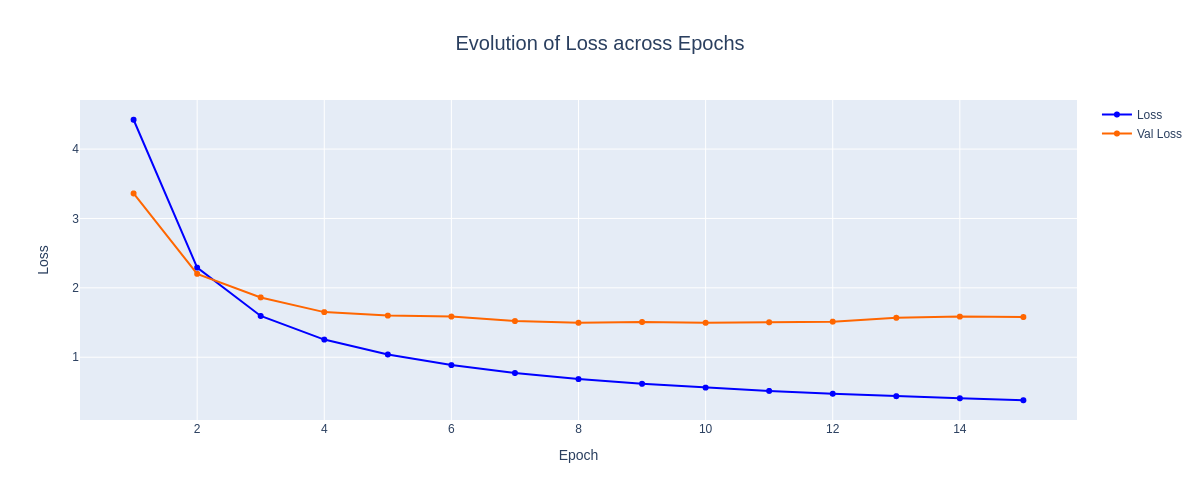

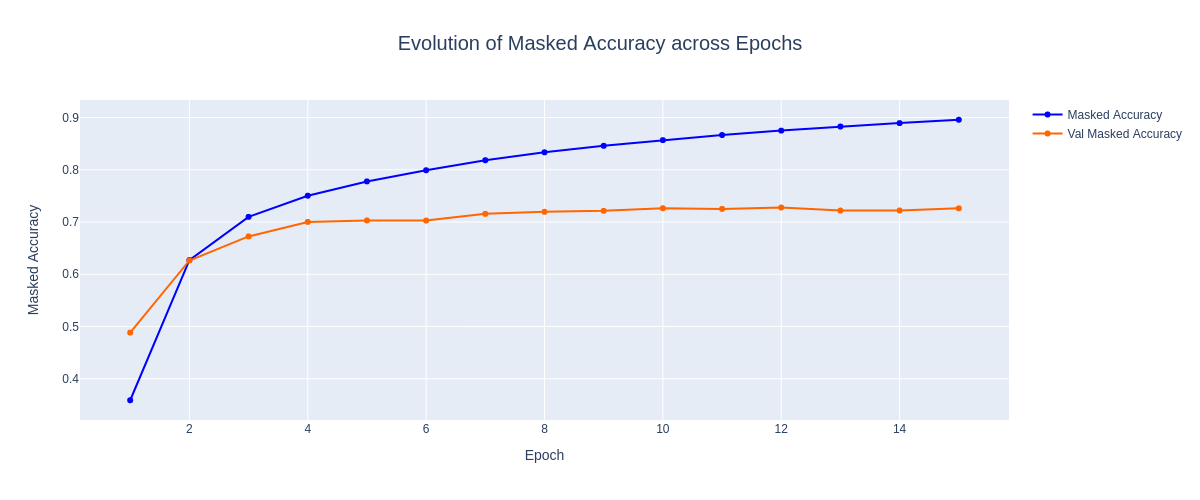

In [ ]:
plot_metrics(renderer="png")
plot_metrics(metric="masked_accuracy", renderer="png")

### **With BLEU Score**

[BLEU (Bilingual Evaluation Understudy)](https://huggingface.co/spaces/evaluate-metric/bleu) is an algorithm used to evaluate the quality of automatically translated text between languages. It uses a scoring range from 0 to 100, where a score of 100 represents a perfect translation. Evaluations are performed on individual translated segments by comparing them to a set of high-quality reference translations.

To facilitate the evaluation of machine translation models using BLEU, [SacreBLEU](https://huggingface.co/spaces/evaluate-metric/sacrebleu) is employed. SacreBLEU is a specific implementation of BLEU within the SacreBLEU library, which provides additional tools and specific adjustments to simplify and standardize the evaluation of machine translations.

In [ ]:
val_contexts = contexts[~is_train]
val_targets= targets[~is_train]

In [ ]:
token_start = list(target_vocab).index("[START]")
token_end = list(target_vocab).index("[END]")

token_start, token_end

(2, 3)

**Class for generating translations from English to Spanish**

To determine the best translation, we will consider the last logit (score) of the sequence predicted by the model, as it encapsulates information from the entire sequence. While this method doesn't work perfectly in all cases, it performs well for quick and straightforward translations.

In [ ]:
class GenerateTranslation():
  def __init__(self, model, units):
    self.model = model
    self.units = units
    # Mask to discard [UNK] tokens and padding tokens
    self.mask = tf.scatter_nd(
        indices=[[0], [1]],
        updates=[-float("inf"), -float("inf")],
        shape=[target_vocab_size]
    )

  @tf.function #Transforming the function into an optimized computational graph to accelerate prediction
  def generate_next_token(self, encoded_context, next_token, states, end, temperature):
    logits, states = self.model.decoder_model(encoded_context, next_token, states, return_state=True)
    logits = logits[:, -1, :]
    temperature = tf.cast(temperature, logits.dtype)

    if temperature == 0:
      logits += self.mask
      next_token = tf.argmax(logits, axis=-1)
    else:
      logits /= temperature
      logits += self.mask
      next_token = tf.random.categorical(logits, num_samples=1)[0]

    if next_token == token_end:
      end = True
    logit = tf.gather(logits[0], next_token)

    return next_token[None, :], logit, states, end

  def translate(self, text, max_length=100, temperature=0.0):
    tokens, logits = [], []

    context = context_vectorizer([text]).to_tensor()
    next_token = tf.constant(token_start, shape=(1, 1))
    states = [tf.zeros((1, self.units)), tf.zeros((1, self.units))]
    end = False

    encoded_context = self.model.encoder_model(context)

    for _ in range(max_length):
      next_token, logit, states, end = self.generate_next_token(
          encoded_context,
          next_token,
          states,
          end,
          temperature
      )
      if end:
        break

      tokens.append(next_token.numpy().squeeze())
      logits.append(logit.numpy()[0])

    translated_text = " ".join(target_vocab[tokens])
    translated_text = self.remove_punctuation_spaces(translated_text)

    return translated_text, logits[-1]

  # Method to generate multiple translations with varying temperatures
  def generate_samples(self, text, max_length=100, max_temperature=1.0, n_samples=3, n_best_size=10):
    samples = []

    for t in np.arange(0, max_temperature+0.2, 0.2):
      sample_range = 1 if t == 0 else n_samples

      for _ in range(sample_range):
        sample, score = self.translate(text, max_length, t)
        samples.append({
            "translated_text": sample,
            "score": score
        })
    samples = sorted(samples, key=lambda x: x["score"], reverse=True)[:n_best_size]

    return samples

  def remove_punctuation_spaces(self, text):
    text = re.sub(r"\s([.,;:?!])", r"\1", text)
    text = re.sub(r"([¿¡])\s", r"\1", text)
    return text

In [ ]:
translate = GenerateTranslation(model, embedding_dim)

In [ ]:
# Translation example
tf.random.set_seed(123)
translate.generate_samples("I'm from Peru.")

[{'translated_text': 'soy de peru.', 'score': 70.19684},
 {'translated_text': 'soy de peru.', 'score': 70.19684},
 {'translated_text': 'soy de peru.', 'score': 70.19684},
 {'translated_text': 'soy de peru.', 'score': 35.09842},
 {'translated_text': 'soy de peru.', 'score': 35.09842},
 {'translated_text': 'soy el peru.', 'score': 32.206764},
 {'translated_text': 'soy del peru.', 'score': 23.447515},
 {'translated_text': 'soy de peru.', 'score': 23.398945},
 {'translated_text': 'soy el peru.', 'score': 21.471176},
 {'translated_text': 'soy el aullar de peru.', 'score': 18.252928}]

**Load the Evaluation Metric**

In [ ]:
metric = load("sacrebleu")
metric

EvaluationModule(name: "sacrebleu", module_type: "metric", features: [{'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}], usage: """
Produces BLEU scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions (`list` of `str`): list of translations to score. Each translation should be tokenized into a list of tokens.
    references (`list` of `list` of `str`): A list of lists of references. The contents of the first sub-list are the references for the first prediction, the contents of the second sub-list are for the second prediction, etc. Note that there must be the same number of references for each prediction (i.e. all sub-lists must be of the same length).
    smooth_method (`str`): The smoothing method to use, defaults to `'e

**Function to calculate BLEU score given a list of texts and a list with their reference or references**

In [ ]:
def evaluate_bleu_score(contexts, targets, n_samples=3):
  def normalize_target(text):
    text = tf_text.normalize_utf8(text, "NFKD")
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, r"[^ a-z0-9.,;:¿?¡!-]", "")
    return text.numpy().decode("utf-8")

  predictions, references, scores = [], [], []
  for i in tqdm(range(len(contexts))):
    prediction = translate.generate_samples(contexts[i], n_samples=n_samples)[0]["translated_text"]

    reference = targets[i]
    if type(reference) == list:
      reference = [normalize_target(r) for r in reference]
    else:
      reference = [normalize_target(reference)]

    score = metric.compute(
        predictions=[prediction],
        references=[reference],
        use_effective_order=True
    )["score"]

    predictions.append(prediction)
    references.append(reference)
    scores.append(score)

  return predictions, references, scores

In [ ]:
# Calculating the BLEU score for the evaluation dataset
tf.random.set_seed(SEED)
predictions, references, scores = evaluate_bleu_score(
    val_contexts,
    val_targets
)

print(f"BLEU Score: {np.mean(scores)}")

  0%|          | 0/2119 [00:00<?, ?it/s]

BLEU Score: 37.330135784629014


In [ ]:
metric.compute(predictions=predictions, references=references)

{'score': 33.21515887588383,
 'counts': [10424, 5739, 3316, 1853],
 'totals': [16572, 14453, 12334, 10223],
 'precisions': [62.9012792662322,
  39.70801909638137,
  26.885033241446408,
  18.125794776484398],
 'bp': 1.0,
 'sys_len': 16572,
 'ref_len': 14924}

The BLEU score of the model on the evaluation dataset is **37.33**. Calculated individually, this value is more accurate due to the use of the `use_effective_order=True` argument, which considers only n-grams that match the length of the evaluated text. In contrast, the joint calculation yields a score of 33.22, which is less precise. This discrepancy occurs because when sequences are shorter than the n-grams considered by the metric, a score of 0 is assigned, even if the prediction and the reference are identical.

A BLEU score of 37.33 indicates that the model produces translations of low to medium quality. This score would increase if multiple references were considered for each translated text, as there are often several possible translations when switching between languages. As we will see later when generating translations, the model achieves a perfect score of 100 on short texts, but as texts become longer, its performance decreases, resulting in an overall score of 37.33 on the evaluation dataset.

## **Translate from English to Spanish**

In [ ]:
# Load the trained model
tf.keras.backend.clear_session()

model = tf.keras.models.load_model(
    trained_model_path,
    custom_objects={
        "masked_loss": masked_loss,
        "masked_accuracy": masked_accuracy
    }
)
model.call([tf.keras.Input(shape=(None,)), tf.keras.Input(shape=(None,))])
model.summary()

Model: "translator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, None, 256)         4683008   
                                                                 
 decoder (Decoder)           (None, None, 25000)       14139304  
                                                                 
Total params: 18822312 (71.80 MB)
Trainable params: 18822312 (71.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Function to generate translations and display them in HTML format
def display_translation(text, reference=None, n_samples=3):
  if reference is not None:
    prediction, reference, score = evaluate_bleu_score(
        [text],
        [reference],
        n_samples=n_samples
    )

    display(HTML(f"""
    <b>English Text:</b> {text}<br>
    <b>Spanish Translation:</b> {prediction[0]}<br>
    <b>Reference Translations:</b> {reference[0]}<br><br>
    <b><span style="color: blue">BLEU Score:</span></b> {round(score[0], 2)}
    """))
  else:
    prediction = translate.generate_samples(text, n_samples=n_samples)[0]["translated_text"]
    display(HTML(f"""
    <b>English Text:</b> {text}<br>
    <b>Spanish Translation:</b> {prediction}
    """))

In [ ]:
# Without references
display_translation("See you later.")

In [ ]:
display_translation(
    text="I was born in Spain.",
    reference=["Nací en España.", "Yo nací en España"]
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
display_translation(
    text="How old are you?",
    reference="¿Cuántos años tienes?"
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
display_translation(
    text="Where are you from?",
    reference=["¿De qué lugar eres?", "¿De dónde eres?", "¿De dónde sos?"]
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
display_translation(
    text="You did an excellent job!",
    reference="¡Hiciste un trabajo excelente!"
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
display_translation(
    text="I like to learn, that's why I study at the university.",
    reference="Me gusta aprender, por eso estudio en la universidad."
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
display_translation(
    text="Tomorrow, we will visit our grandparents who live in the countryside.",
    reference=[
        "Mañana visitaremos a nuestros abuelos que viven en el campo.",
        "Mañana vamos a visitar a nuestros abuelos que viven en el campo.",
    ]
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
display_translation(
    text="Can you please help me with this task, please?",
    reference="¿Puedes ayudarme con esta tarea, por favor?"
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
display_translation(
    text="I am going to the store to buy some groceries.",
    reference=[
        "Voy a la tienda para comprar algunos alimentos.",
        "Voy a la tienda a comprar algunas provisiones."
    ]
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Long text
display_translation(
    text="When she arrived at the train station, she realized she had forgotten her ticket at home and had to rush back to retrieve it.",
    reference="Cuando llegó a la estación de tren, ella se dio cuenta de que había olvidado su boleto en casa y tuvo que volver corriendo a buscarlo."
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Long text
display_translation(
    text="In ten years, he will have his own company, will have become a successful professional worldwide, and will be helping many people in his country.",
    reference="En diez años, él tendrá su propia empresa y se habrá convertido en un profesional exitoso en el mundo y ayudará a muchas personas de su país."
)

  0%|          | 0/1 [00:00<?, ?it/s]

**Conclusion:** The model is excellent for translating short to medium-length texts, achieving a BLEU score close to 100. However, its performance decreases as texts become longer. To enhance its robustness with longer texts, it would be beneficial to feed the model with its own predictions using a self-attention mechanism, similar to that used in Transformer networks. This would allow the decoder to examine what it has generated so far and adjust its predictions accordingly.